<p style='color:#af0fa2; font-size:32px; text-align:left'> <strong> Analyse des transcripts  </strong>
</p>
<p style='color:grey; font-size:24px; text-align:right'>Natural Language Processing</p>

<!-- 
 <p style="color:#af0fa2;"> 
✔ Data preprocessing<br>
✔ Training set/Testing set/Validation set <br>
✔ Model/Hyperparameters optimization <br>
✔ Training of the model  <br>
✔ Evaluation of the model <br>
✔ Classifications <br>
</p> -->

In [2]:
import pandas as pd 
from nltk.corpus import abc
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from collections import defaultdict
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve, auc
np.random.seed(42)
from pprint import pprint
# import altair as alt
# alt.renderers.enable("notebook")

[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from spacy.lang.en.stop_words import STOP_WORDS

In [4]:
stopwords_spacy=list(STOP_WORDS)

In [5]:
transcript=pd.read_csv('/home/alex/SimplonIA/Enfer/Projet_ML/data/overview-of-recordings.csv', sep=',')

In [7]:
transcript.loc[transcript['phrase'] == 'When I carry heavy things I feel like breaking my back', 'prompt'] = "Back pain"

In [8]:
transcript.loc[transcript['phrase'] == 'My muscles in my lower back are aching', 'prompt'] = "Muscle pain"

In [9]:
transcript.loc[transcript['phrase'] == 'I have muscle pain in my left leg', 'prompt'] = "Muscle pain"

In [10]:
transcript.loc[transcript['phrase'] == 'I have a strange rash on my arm', 'prompt'] = "Skin issue"

In [11]:
transcript.loc[transcript['phrase'] == "Don't cry", 'prompt'] = "Emotional pain"

In [12]:
transcript.loc[transcript['phrase'] == "i cant sleep because of cold", 'prompt'] = "Feeling cold"

In [13]:
transcript.loc[transcript['phrase'] == "My infected wound cause fever", 'prompt'] = "Infected wound"

In [14]:
transcript.loc[transcript['phrase'] == "I lose a lot of my hair", 'prompt'] = "Hair falling out"

In [16]:
import re
string_to_replace = ["can't"]
string_to_replace_2 = ["doesn't"]
regex_string = r"|".join(string_to_replace)
regex_string_2 = r"|".join(string_to_replace_2)
# 0 strip the string from both sides from the whitespaces
# 1. introduce a whitespace after  , et  ;
# 2. strip whitespace from before but not after punctuation et - et + 
transcript['phrase_transform'] = transcript['phrase'].apply(lambda x: str(x).strip().lower())
transcript['phrase_transform'] = transcript['phrase'].apply(lambda x: re.sub(r'(?<=[,;])(?=[^\s])', r' ',str(x)))
transcript['phrase_transform'] = transcript['phrase'].apply(lambda x: re.sub(r'\s([-,.;+:"](?:\s|$))', r'\1',str(x)))
transcript['phrase_transform'] = transcript['phrase_transform'].apply(lambda x: re.sub(regex_string, "cannot", str(x), flags=re.I))
transcript['phrase_transform'] = transcript['phrase_transform'].apply(lambda x: re.sub(regex_string_2, "doesnot", str(x), flags=re.I)) 

In [17]:
transcript['record_words_count'] = transcript['phrase'].apply(lambda x: len(str(x).split(" ")))
transcript[['phrase','record_words_count']].head()
transcript['record_words_count'].describe()

count    6661.000000
mean       10.592253
std         4.866114
min         2.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        30.000000
Name: record_words_count, dtype: float64

In [36]:
stop = stopwords.words('english')
trans_phr_analys=transcript.copy()

In [37]:
len(stop), len(stopwords_spacy)

(179, 326)

In [38]:
stop_words_list=[word for word in stopwords_spacy if word not in stop]

In [39]:
len(stop_words_list)

203

In [40]:
stop_words_list=stop_words_list+stop
len(stop_words_list)

382

In [41]:
specific_stop_words=["dr", "cant", "book", "read", "son", 'daughter', "after", "alot", 
                     "name", "phrase", "thing", "father", "brother", "sister", "mother",
                     "others", "dtype", "length", "look", "object", "hour", "object", 
                     "shoelace", "medicine", "paper", "cube", "bag", 'said', "rainy",
                     "soda", "playing", "apply", "parent", "tuesday", "monday", "tuesday",
                     "maybe", "friday", "wednesday", "thursday", "friday", "saturday", 
                     "sunday", "nut", "identify", "waking"]

In [42]:
specific_stop_words_to_remove_from_stopwords=["back", "down", "see", "well", "doesnot","cannot"]

In [43]:
def remove_stop_words(list_stop_wd, wd):
    if not list_stop_wd:
        print("The list of stopwords is empty")
        return []
    if(wd in list_stop_wd):
        list_stop_wd.remove(wd)
    return list_stop_wd

In [44]:
def add_stop_words(list_stop_wd, wd):
    if not list_stop_wd:
        print("The list of stopwords is empty. Adding the word" + str(wd))
        return [str(wd)]
    if(wd not in list_stop_wd):
        list_stop_wd.append(str(wd))
    return list_stop_wd

In [45]:
for wd in specific_stop_words_to_remove_from_stopwords:
    stop_words_list=remove_stop_words(stop_words_list, wd)

In [46]:
for wd in specific_stop_words:
    stop_words_list=add_stop_words(stop_words_list, wd)

In [47]:
len(stop_words_list)

417

In [48]:
"look" in stop_words_list

True

In [49]:
#Removing Punctuation;
tokenizer = nltk.RegexpTokenizer(r'\w+')
translator = str.maketrans('', '', string.punctuation)

In [50]:
trans_phr_analys["phrase_transform"] = trans_phr_analys["phrase_transform"].apply(lambda x: " ".join(x for x in tokenizer.tokenize(str(x))))

In [51]:
frequency_first=pd.Series(' '.join(trans_phr_analys["phrase_transform"]).split()).value_counts()[:50]
frequency_last=pd.Series(' '.join(trans_phr_analys["phrase_transform"]).split()).value_counts()[-50:]

In [52]:
#sort the tf-idf vectors by descending order of scores
def sorting(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [53]:
def extract_keywords(features, sorted_items, how_many=10):
    sorted_items = sorted_items[:how_many]
# """get the feature names and tf-idf score of top n items"""
#use only topn items from vector
    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = features[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(features[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results    

In [59]:
def extract_keywords_from_records(all_records):
     
    cv=CountVectorizer(max_df=0.85,stop_words=stop_words_list)
    word_count_vector=cv.fit_transform(all_records)
    
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    
    features=cv.get_feature_names()
    
    tf_idf_vectors=[tfidf_transformer.transform(cv.transform([all_records[i]])) for i in range(len(all_records))]
    
    sorted_items_list=[sorting(tf_idf_vector.tocoo()) for tf_idf_vector in tf_idf_vectors]
    
    keywords_list=[extract_keywords(features,sorted_items,10) for sorted_items in sorted_items_list]
    
    return keywords_list

In [55]:
def transform_dict_to_df(d):
    return pd.DataFrame.from_dict(d, orient='index', columns=["tf-idf scores"])

In [56]:
from IPython.core.display import display, HTML

def display_side_by_side(dicts:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    
    dicts_df=[transform_dict_to_df(d) for d in dicts]

    combined = dict(zip(captions, dicts_df))        
    for caption, dictionary in combined.items():
        output += dictionary.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [57]:
def pickup_a_record_for_print(number):
# now print the results
    print("\n=====Record=====")
    print(all_records[number])
    print("\n=====Asigned label=====")
    print(trans_phr_analys["prompt"].iloc[number])
    print("\n===Keywords===")
    display_side_by_side([keywords_list[number]], [captions_list[number]])

<p style='color:#af0fa2; font-size:25px; text-align:left'> <strong> Summary 
    </strong>
</p>

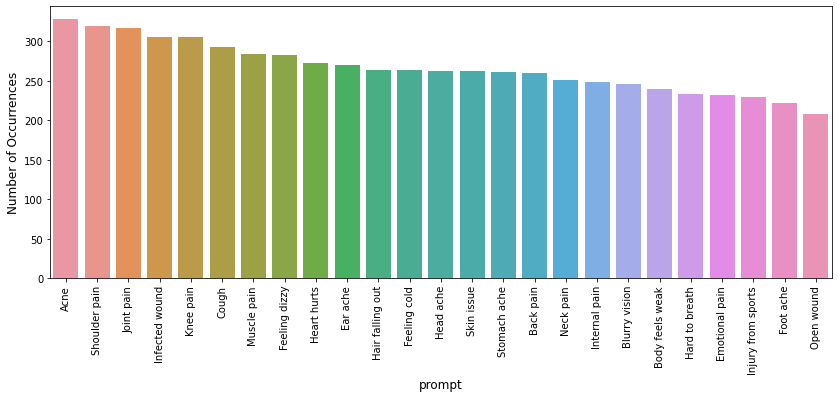

In [61]:
plt.figure(figsize=(14,5))
sns.barplot(x=trans_phr_analys["prompt"].value_counts().index, y=trans_phr_analys['prompt'].value_counts())
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('prompt', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [46]:
transcript["prompt"].unique()

array(['Emotional pain', 'Back pain', 'Heart hurts', 'Infected wound',
       'Muscle pain', 'Foot ache', 'Injury from sports', 'Skin issue',
       'Stomach ache', 'Knee pain', 'Hard to breath', 'Head ache',
       'Feeling cold', 'Hair falling out', 'Feeling dizzy', 'Open wound',
       'Internal pain', 'Body feels weak', 'Blurry vision', 'Acne',
       'Joint pain', 'Shoulder pain', 'Neck pain', 'Cough', 'Ear ache'],
      dtype=object)

In [62]:
def pickup_a_record_for_print_c(number, line):
# now print the results
    print("\n=====Record class=====" + " "+ subsets_df[number]["prompt"].iloc[line])
    print(subset_class(number)[line])
    print("\n=====Asigned label=====")
    print(subsets_df[number]["prompt"].iloc[line])
    print("\n===Keywords===")
    display_side_by_side([keywords_list_c[line]], [captions_list_c[line]])

<p style='color:#af0fa2; font-size:30px; text-align:left'> <strong> Supervised ML studies 
    </strong>
</p>

<img src="supervised-classification.png" width="400" height="200">

In [63]:
transcript.head(1)

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id,phrase_transform,record_words_count
0,no_clipping,1.0,light_noise,1.0,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495,When I remember her I feel down,7


In [64]:
trans_phr_analys_ml=transcript.copy()

In [65]:
trans_phr_analys_ml["phrase_transform"] = trans_phr_analys_ml["phrase_transform"].apply(lambda x: " ".join(x for x in tokenizer.tokenize(str(x))))

In [66]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alex/nltk_data...


------------------------------------------------------------


[nltk_data]   Package wordnet is already up-to-date!


True

<p style='color:#af0fa2; font-size:16px; text-align:left'> <strong> Create a vocabulary  </strong>
</p>

In [67]:
def preprocessing_records (text):
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.lower().translate(translator) 
    text = re.sub("\\W+"," ",text) # remove special chars
    text = re.sub("</?.*?>"," <> ",text)
    text = re.sub('[^a-zA-Z]', ' ', text) #remove punctuations
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text) #remove tags
    text = text.replace("    ", " ")
    text = text.replace("'s", "") # remove possessive pronoun terminations
    
    
    words=re.split("\\s+",text)
#     words=nltk.word_tokenize(text)
    lem = WordNetLemmatizer() #Lemmatisation
    lema_words = [lem.lemmatize(word) for word in words if word not in stop_words_list] 
    return " ".join(lema_words)
    
     
#     stem words
#     stemmer=PorterStemmer()
#     words=re.split("\\s+",text)
#     stemmed_words=[stemmer.stem(word=word) for word in words if word not in stop_words_list]
#     return ' '.join(stemmed_words)

In [68]:
"medicine" in stop_words_list

True

In [69]:
trans_phr_analys_ml["phrase"]=trans_phr_analys_ml["phrase"].apply(lambda x: str(x).strip().lower())
trans_phr_analys_ml["phrase"]=trans_phr_analys_ml["phrase"].apply(lambda x: re.sub(r'(?<=[,;])(?=[^\s])', r' ',str(x)))
trans_phr_analys_ml["phrase"]=trans_phr_analys_ml["phrase"].apply(lambda x: re.sub(r'\s([-,.;+:"](?:\s|$))', r'\1',str(x)))
trans_phr_analys_ml['phrase'] = trans_phr_analys_ml["phrase"].apply(lambda x: re.sub(regex_string, "cannot", str(x), flags=re.I))
trans_phr_analys_ml['phrase'] = trans_phr_analys_ml["phrase"].apply(lambda x: re.sub(regex_string_2, "doesnot", str(x), flags=re.I))
trans_phr_analys_ml["phrase"]=trans_phr_analys_ml["phrase"].apply(lambda x: " ".join(x for x in tokenizer.tokenize(str(x))))

In [70]:
trans_phr_analys_ml['phrase_transform'].values[6659], trans_phr_analys_ml["phrase"].values[6659
                                                                                    ]

('The area around my heart doesnot feel good',
 'the area around my heart doesnot feel good')

In [71]:
trans_phr_analys_ml["phrase"] = trans_phr_analys_ml["phrase"].apply(lambda x:preprocessing_records(str(x)))

In [72]:
%%capture
trans_phr_analys_ml["phrase"]

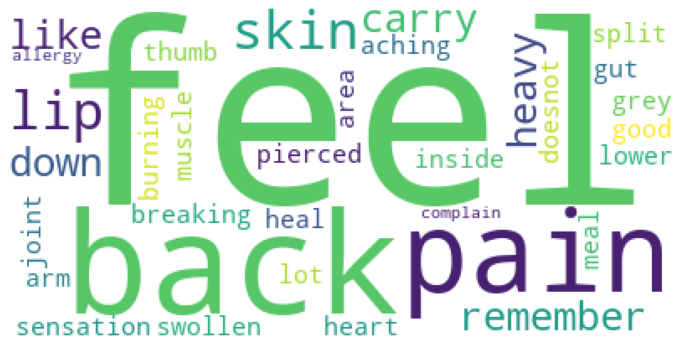

In [74]:
#Word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words_list,
                          max_words=100,
                          max_font_size=150, 
                          random_state=42
                          ).generate(str(trans_phr_analys_ml["phrase"]))

print(wordcloud)
fig = plt.figure(1, figsize=(12, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
# fig.savefig("word1.png", dpi=900)

In [75]:
%%capture
trans_phr_analys_ml["phrase"].values[17], transcript["phrase"].values[17]

In [76]:
all_records=trans_phr_analys_ml["phrase"].tolist()
cv=CountVectorizer(max_df=0.85,stop_words=stop_words_list)
word_count_vector=cv.fit_transform(all_records)

In [77]:
trans_phr_analys_ml["phrase"]

0                                      remember feel down
1               carry heavy thing feel like breaking back
2                                                pain arm
3       lip pierced swollen skin inside lip grey look ...
4                                muscle lower back aching
                              ...                        
6656                 feel burning sensation gut hour meal
6657                                     split thumb heal
6658                                  feel lot pain joint
6659                         area heart doesnot feel good
6660                                complain skin allergy
Name: phrase, Length: 6661, dtype: object

In [74]:
len(set(list(cv.vocabulary_.items())))

865

In [78]:
#Most frequently occuring words
def get_top_n_words(records, n=None):
    vec = CountVectorizer().fit(records)
    bag_of_words = vec.transform(records)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

In [79]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(all_records, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Frequency"]
top_df.head(5)

,Word,Frequency
0,feel,1813
1,pain,1634
2,cannot,596
3,hurt,526
4,like,507


In [80]:
#Most frequently occuring Bi-grams
def get_top_n2_words(records, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(records)
    bag_of_words = vec1.transform(records)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]


top2_words = get_top_n2_words(all_records, n=20)


top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Frequency"]

print(top2_df)

#Barplot of most freq Bi-grams
%%capture
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Frequency", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90)

          Bi-gram  Frequency
0       feel pain        316
1       feel like        305
2      sharp pain        181
3      feel dizzy        159
4       feel weak        117
5    hair falling        102
6   blurry vision         89
7       pain knee         85
8   shoulder pain         82
9       body feel         82
10      feel cold         80
11   pain stomach         79
12     great pain         78
13     feel great         75
14      pain back         65
15       ear ache         63
16      pain foot         63
17      back hurt         61
18   cannot stand         60
19     lower back         59


UsageError: Line magic function `%%capture` not found.


https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

<p style='color:#af0fa2; font-size:16px; text-align:left'> <strong> Tf-idf Transformer to Compute Inverse Document Frequency (IDF)  </strong>
</p>

In [81]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
tfidf_transformer.idf_

array([6.54607848, 7.0315863 , 7.50158993, 7.85826487, 6.91380326,
       7.50158993, 6.85973604, 3.9752294 , 5.97553362, 4.71657868,
       6.80844275, 7.72473348, 7.60695044, 7.40627975, 7.60695044,
       7.60695044, 6.11529556, 7.40627975, 7.72473348, 7.31926837,
       7.40627975, 7.50158993, 5.27157553, 7.50158993, 7.40627975,
       7.40627975, 7.85826487, 7.31926837, 6.62612119, 7.85826487,
       7.31926837, 7.60695044, 6.33843912, 4.8205684 , 7.60695044,
       7.85826487, 6.75965258, 7.23922566, 7.23922566, 5.77882333,
       7.40627975, 7.40627975, 3.84575033, 5.77882333, 5.67704063,
       7.60695044, 7.50158993, 6.91380326, 6.47197051, 6.37018781,
       7.40627975, 7.31926837, 7.40627975, 7.60695044, 7.40627975,
       7.23922566, 5.47344168, 7.50158993, 5.67704063, 6.43687919,
       7.60695044, 6.33843912, 7.0315863 , 7.50158993, 7.50158993,
       7.40627975, 6.0665054 , 6.58529919, 7.40627975, 7.31926837,
       7.50158993, 5.11282714, 4.18377415, 6.43687919, 6.85973

In [85]:
keywords_list=extract_keywords_from_records(all_records)

In [90]:
captions_list=["record"+str(i) for i in range(len(keywords_list))]
len(captions_list)

6661

In [91]:
def pickup_a_record_for_print(number):
# now print the results
    print("\n=====Record=====")
    print(all_records[number])
    print("\n=====Asigned label=====")
    print(trans_phr_analys["prompt"].iloc[number])
    print("\n===Keywords===")
    display_side_by_side([keywords_list[number]], [captions_list[number]])

In [92]:
pickup_a_record_for_print(4)


=====Record=====
muscle lower back aching

=====Asigned label=====
Muscle pain

===Keywords===


,tf-idf scores
aching,0.594000
lower,0.538000
muscle,0.461000
back,0.382000


In [93]:
n=input("Picup a record to print ")
pickup_a_record_for_print(int(n))

Picup a record to print 1

=====Record=====
carry heavy feel like breaking back

=====Asigned label=====
Back pain

===Keywords===


,tf-idf scores
breaking,0.567000
carry,0.515000
heavy,0.423000
back,0.323000
like,0.302000
feel,0.195000


<p style='color:#af0fa2; font-size:22px; text-align:left'> <strong> Encoding  </strong>
</p>

In [82]:
text_labels = trans_phr_analys_ml[["phrase", "prompt"]]

In [83]:
X = trans_phr_analys_ml["phrase"]
y = trans_phr_analys_ml["prompt"]

In [84]:
trans_phr_analys_ml["prompt"].head(2)

0    Emotional pain
1         Back pain
Name: prompt, dtype: object

In [85]:
le = LabelEncoder()
y=le.fit_transform(y)

In [86]:
lb = LabelBinarizer()
y_binarizer=lb.fit_transform(y)
y_binarizer

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [87]:
# Binarize the output variable
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
n_classes = y.shape[1]

In [88]:
is_all_zero = np.all((y == 0))
is_all_zero

False

In [89]:
y[1]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [90]:
label_classes = {k:v for k,v in zip(list(trans_phr_analys_ml["prompt"]),y_binarizer.tolist())}

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_binarizer, 
                                                    test_size=0.2, 
                                                    random_state=42, stratify=y)

> TF-IDF Vectors are used as features 

In [92]:
tfidf_vectorizer  = TfidfVectorizer(min_df=2, 
                                    stop_words=None, 
                                    encoding='utf-8',
                                    ngram_range=(1,1),
                                    lowercase=False,
                                    use_idf=True, 
                                    smooth_idf=True)

X_features_train = tfidf_vectorizer.fit_transform(X_train).toarray()
y_labels_train = y_train

print(X_features_train.shape)

X_features_test = tfidf_vectorizer.transform(X_test).toarray()
y_labels_test = y_test
print(X_features_test.shape)

(5328, 882)
(1333, 882)


In [93]:
tfidf_vectorizer.get_feature_names()

['abdomen',
 'abdominal',
 'able',
 'abronchial',
 'accident',
 'accidentally',
 'accompanied',
 'ache',
 'aching',
 'acne',
 'active',
 'actually',
 'acupuncture',
 'adult',
 'affected',
 'afraid',
 'ago',
 'agreat',
 'air',
 'allergy',
 'analysis',
 'anemia',
 'ankle',
 'annoyance',
 'annoying',
 'annoys',
 'answer',
 'antibiotic',
 'anymore',
 'anytime',
 'appendicitis',
 'arch',
 'area',
 'arm',
 'arrived',
 'asthma',
 'ate',
 'attack',
 'awake',
 'away',
 'awful',
 'bacause',
 'back',
 'bad',
 'badly',
 'bald',
 'ball',
 'barely',
 'basketball',
 'bear',
 'beating',
 'bed',
 'beeing',
 'beginning',
 'believe',
 'belly',
 'bend',
 'bent',
 'better',
 'bicep',
 'biceps',
 'big',
 'bike',
 'bit',
 'blackhead',
 'blanket',
 'bleeding',
 'bloating',
 'blood',
 'blur',
 'blurred',
 'blurry',
 'body',
 'bone',
 'book',
 'bother',
 'bottom',
 'bowel',
 'brain',
 'break',
 'breaking',
 'breakout',
 'breakup',
 'breath',
 'breathe',
 'breathing',
 'breathless',
 'bright',
 'broke',
 'broken

> $\Chi^{2}$ test in order to see what unigrams are most correlated with each labels'class.

In [94]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, label_id in sorted(label_classes.items()):
    features_chi2 = chi2(X_features_train, y_labels_train == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("")

# 'Acne' category:
  . Most correlated unigrams:
. patch
. disease
. pimple
. face
. acne

# 'Back pain' category:
  . Most correlated unigrams:
. tie
. spine
. lower
. bend
. back

# 'Blurry vision' category:
  . Most correlated unigrams:
. quick
. eye
. see
. blurry
. vision

# 'Body feels weak' category:
  . Most correlated unigrams:
. energy
. strength
. tired
. body
. weak

# 'Cough' category:
  . Most correlated unigrams:
. breathe
. mucus
. coughing
. throat
. cough

# 'Ear ache' category:
  . Most correlated unigrams:
. ringing
. tinnitus
. unbearable
. hearing
. ear

# 'Emotional pain' category:
  . Most correlated unigrams:
. breakup
. suicidal
. parent
. disappointed
. sad

# 'Feeling cold' category:
  . Most correlated unigrams:
. high
. chill
. temperature
. warm
. cold

# 'Feeling dizzy' category:
  . Most correlated unigrams:
. quickly
. stand
. spinning
. lightheaded
. dizzy

# 'Foot ache' category:
  . Most correlated unigrams:
. relaxing
. knocked
. arch
. heel
. foot

<p style='color:#af0fa2; font-size:25px; text-align:left'> <strong> SVM  </strong>
</p>

In [95]:
classifier_svm = OneVsRestClassifier(SVC(kernel='linear', probability=True,
                                 random_state=42))

In [96]:
classifier_svm.fit(X_features_train, y_labels_train)

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True,
                                  random_state=42))

In [97]:
classifier_svm.n_classes_

25

In [102]:
y_proba_svm = classifier_svm.predict_proba(X_features_test)

In [101]:
y_proba_svm

array([[7.75885675e-05, 9.97570470e-05, 3.91889102e-04, ...,
        2.15264530e-04, 9.30398547e-04, 5.61552571e-04],
       [1.00000000e+00, 1.27357494e-05, 1.12198755e-04, ...,
        2.83133433e-04, 9.32273050e-04, 1.48915456e-03],
       [2.07834626e-04, 2.19090680e-04, 2.88625113e-04, ...,
        2.75254473e-04, 3.45018381e-04, 1.72255335e-03],
       ...,
       [5.41373961e-05, 4.08166128e-04, 1.26899988e-05, ...,
        5.33802776e-05, 2.65988243e-05, 6.55065905e-04],
       [1.29439415e-04, 2.22236113e-04, 1.53640630e-04, ...,
        9.96643359e-01, 3.61638763e-04, 2.72346998e-05],
       [2.74618393e-05, 1.99056934e-04, 1.59821561e-04, ...,
        6.99076323e-05, 1.99957128e-04, 2.08720674e-03]])

In [103]:
y_pred_svm=classifier_svm.predict(X_features_test)

In [114]:
y_test_non_category = [ np.argmax(t) for t in y_labels_test ]
y_pred_non_category = [ np.argmax(t) for t in y_pred_svm ]

from sklearn.metrics import confusion_matrix
conf_mat_svm = confusion_matrix(y_test_non_category, y_pred_non_category)

In [115]:
def plot_cm(cm, title, classes, normalize=False):

    plt.imshow(cm, interpolation='nearest', cmap="Blues")
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    
    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=12)

In [116]:
plt.style.use('classic')
class_names = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

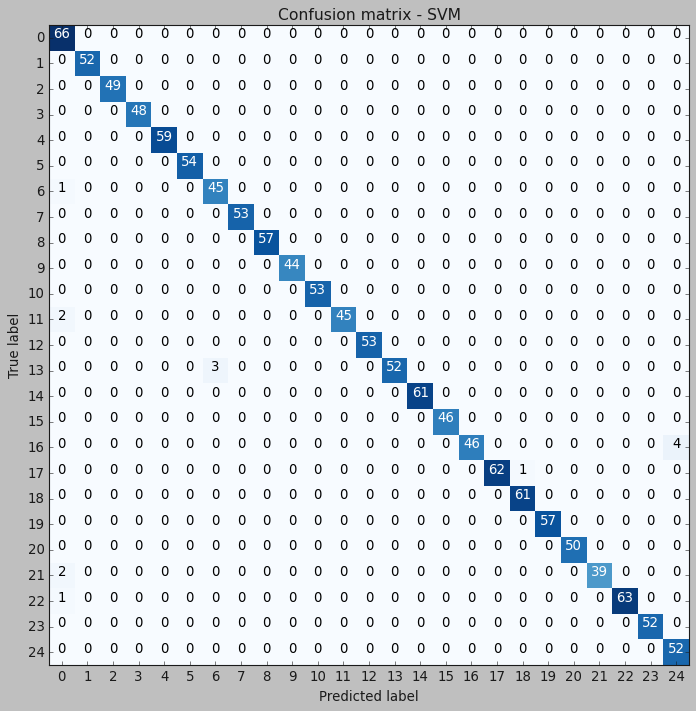

In [117]:
fig = plt.figure(figsize = (22,10))
plot_cm(conf_mat_svm, "Confusion matrix - SVM", class_names, normalize=False)

In [118]:
classifier_svm.score(X_features_test, y_labels_test)

0.9887471867966992

In [120]:
print("Score within train :",classifier_svm.score(X_features_train,y_labels_train))
print("Score within test :",classifier_svm.score(X_features_test, y_labels_test))

Score within train : 0.9861111111111112
Score within test : 0.9887471867966992


In [121]:
 classifier_svm.predict_proba(X_features_test)

array([[7.64329154e-05, 1.36978494e-04, 3.88523715e-04, ...,
        8.40639230e-04, 9.22561230e-04, 5.04897243e-04],
       [1.00000000e+00, 1.28740545e-05, 9.80264870e-05, ...,
        1.10848029e-03, 9.18694569e-04, 1.43242013e-03],
       [2.11651262e-04, 2.63016742e-04, 3.24248137e-04, ...,
        1.01287787e-03, 3.51792137e-04, 1.77211680e-03],
       ...,
       [6.57769701e-05, 5.32112544e-04, 1.12212256e-05, ...,
        2.31988622e-04, 2.85597439e-05, 6.42568613e-04],
       [1.23658644e-04, 1.73496871e-04, 1.37028786e-04, ...,
        9.96949108e-01, 3.53258217e-04, 2.79571189e-05],
       [3.91988692e-05, 2.52142738e-04, 8.94369590e-05, ...,
        2.66535045e-04, 2.21007365e-04, 2.11758953e-03]])

In [123]:
print('Parameters currently in use:\n')
pprint(classifier_svm.get_params())

Parameters currently in use:

{'estimator': SVC(kernel='linear', probability=True, random_state=42),
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'linear',
 'estimator__max_iter': -1,
 'estimator__probability': True,
 'estimator__random_state': 42,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'n_jobs': None}



- C: Penalty parameter C of the error term.
- kernel: Specifies the kernel type to be used in the algorithm.
- gamma: Kernel coefficient.
- degree: Degree of the polynomial kernel function.

<p style='color:#af0fa2; font-size:23px; text-align:left'> <strong> Randomized cross-validation </strong>
</p>

In [147]:
# C
estimator__C = [.0001, .001, .01, 1., 10]

# gamma
estimator__gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
estimator__degree = [1, 2, 3, 4, 5]

# kernel
estimator__kernel = ['linear', 'rbf', 'poly']

# probability
estimator__probability = [True]

estimator__random_state=42

# Create the random grid
random_grid = {'estimator__C': estimator__C,
              'estimator__kernel': estimator__kernel,
              'estimator__gamma': estimator__gamma,
              'estimator__degree': estimator__degree,
              'estimator__probability': estimator__probability,
             }
pprint(random_grid)

{'estimator__C': [0.0001, 0.001, 0.01, 1.0, 10],
 'estimator__degree': [1, 2, 3, 4, 5],
 'estimator__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'estimator__kernel': ['linear', 'rbf', 'poly'],
 'estimator__probability': [True]}


In [148]:
# Create the base model to tune
svc =SVC(random_state=42)
clf_svm = OneVsRestClassifier(SVC())

# Random search
random_search = RandomizedSearchCV(estimator=clf_svm,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X_features_train, y_labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 683.3min finished


RandomizedSearchCV(cv=3, estimator=OneVsRestClassifier(estimator=SVC()),
                   n_iter=50,
                   param_distributions={'estimator__C': [0.0001, 0.001, 0.01,
                                                         1.0, 10],
                                        'estimator__degree': [1, 2, 3, 4, 5],
                                        'estimator__gamma': [0.0001, 0.001,
                                                             0.01, 0.1, 1, 10,
                                                             100],
                                        'estimator__kernel': ['linear', 'rbf',
                                                              'poly'],
                                        'estimator__probability': [True]},
                   random_state=42, scoring='accuracy', verbose=1)

In [132]:
clf_svm.get_params().keys()

dict_keys(['estimator__C', 'estimator__break_ties', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs'])

In [149]:
print("The best hyperparameters from SVM are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from SVM are:
{'estimator__probability': True, 'estimator__kernel': 'linear', 'estimator__gamma': 0.001, 'estimator__degree': 5, 'estimator__C': 10}

The mean accuracy of a model with these hyperparameters is:
0.9947447447447447


In [108]:
def choose_kernel(kernel, X_train, y_train, X_test, y_test):
    
    svc_model=OneVsRestClassifier(SVC(kernel=kernel, C=10, probability=True,
                                      gamma=0.001, degree=5, random_state=42))
    svc_model.fit(X_train, y_train)
    
    score=svc_model.score(X_train, y_train)
    score_test=svc_model.score(X_test, y_test)
    
    y_proba_svc = svc_model.predict_proba(X_test)
    
    y_predict=svc_model.predict(X_test)
    
    accuracy=accuracy_score(y_true=y_test, y_pred=y_predict)
    
    y_test_non_category = [ np.argmax(t) for t in y_test ]
    y_pred_non_category = [ np.argmax(t) for t in y_predict ]


    conf_mat_svm = confusion_matrix(y_test_non_category, y_pred_non_category)
    print(classification_report(y_test, y_predict))
    return score, score_test, accuracy, y_proba_svc, conf_mat_svm 

In [109]:
score_lin, score_test_lin,accuracy_lin, y_proba_svc, cm_lin=choose_kernel('linear', X_features_train, y_labels_train, 
                                              X_features_test, y_labels_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        52
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        48
           4       1.00      1.00      1.00        59
           5       1.00      1.00      1.00        54
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        53
           8       1.00      1.00      1.00        57
           9       1.00      1.00      1.00        44
          10       1.00      1.00      1.00        53
          11       1.00      1.00      1.00        47
          12       1.00      1.00      1.00        53
          13       1.00      1.00      1.00        55
          14       1.00      1.00      1.00        61
          15       1.00      1.00      1.00        46
          16       1.00      0.92      0.96        50
          17       1.00    

In [159]:
score_lin, score_test_lin,accuracy_lin

(0.9968093093093093, 0.9969992498124531, 0.9969992498124531)

In [119]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_labels_test[:, i],  y_proba_svc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_labels_test.ravel(),  y_proba_svc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [117]:
label_dict = {value : key for (value, key) in label_classes.items()}

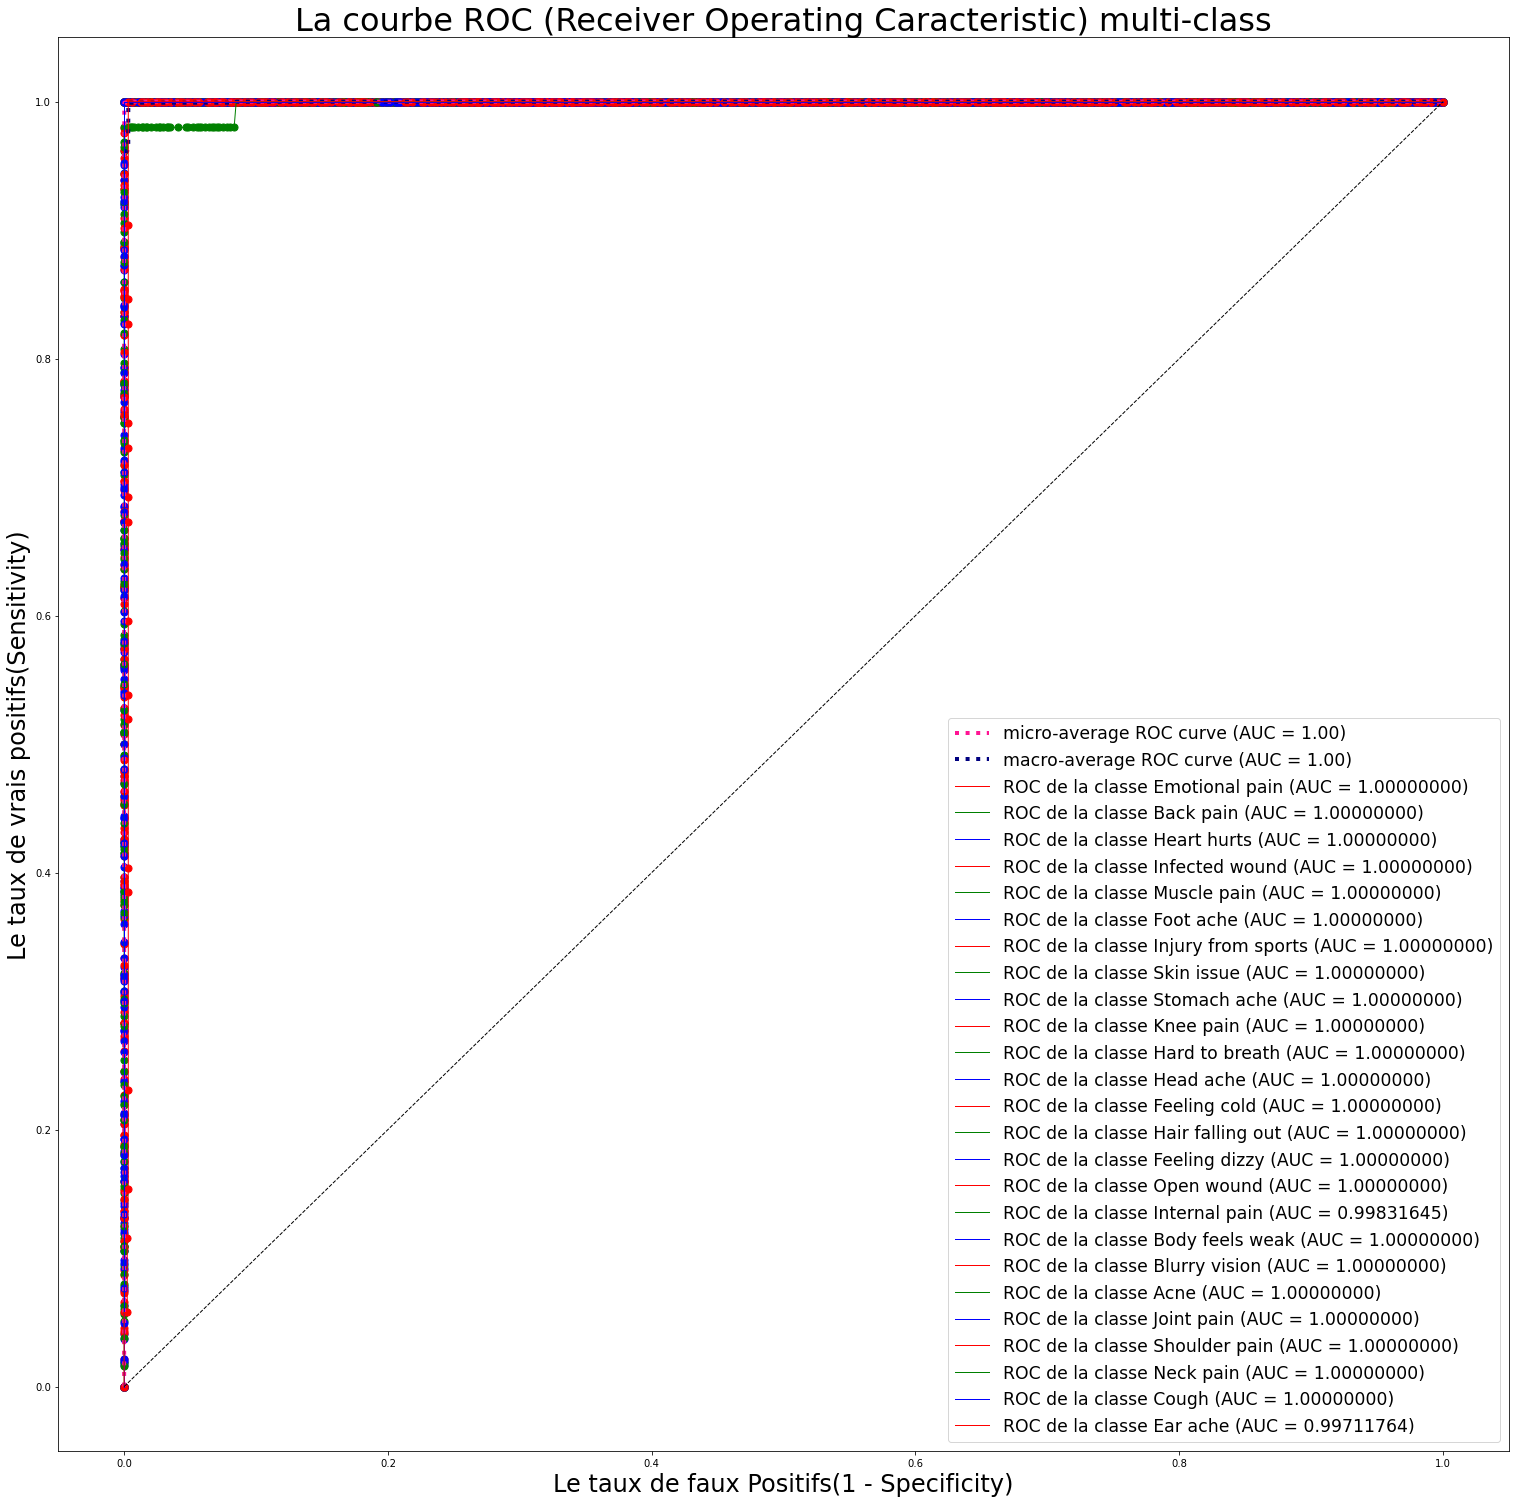

In [123]:
from numpy import interp
from itertools import cycle
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.figure(figsize=(26,26))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['red', 'green', 'blue'])

label_dict = {value : key for (value, key) in label_classes.items()}
lw = 1
for i, color in zip(range(n_classes), colors):
    plt.scatter( fpr[i], tpr[i], color=color, s=50)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC de la classe '+list(label_dict.keys())[i]+' (AUC = {1:0.8f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Le taux de faux Positifs(1 - Specificity)',size=24)
plt.ylabel('Le taux de vrais positifs(Sensitivity)',size=24)
plt.title('La courbe ROC (Receiver Operating Caracteristic) multi-class',size=32)
plt.legend(loc="lower right", fontsize = 'xx-large')
plt.show()

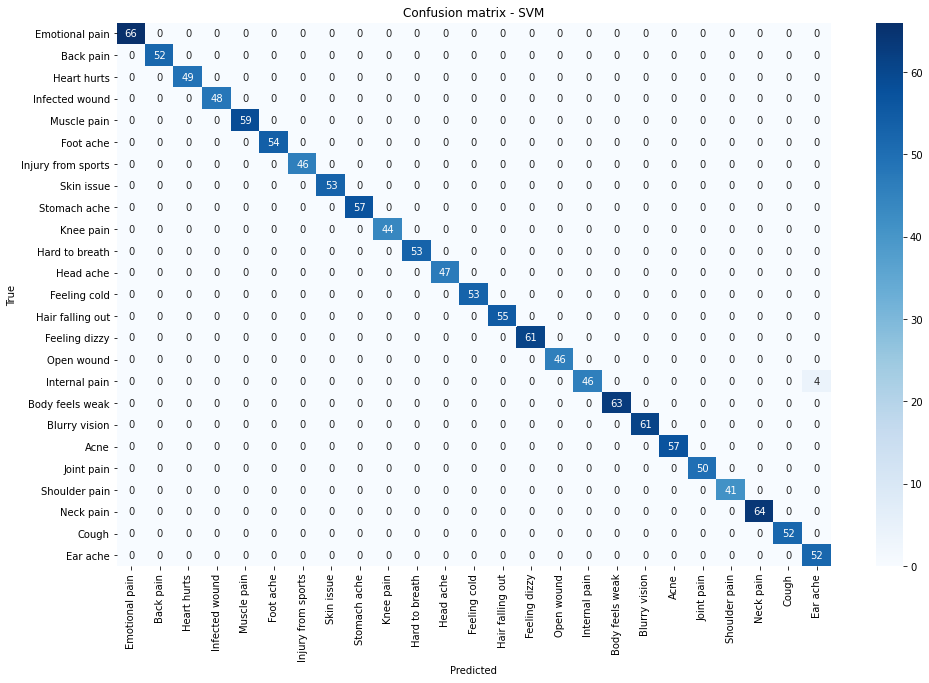

In [126]:
plt.figure(figsize=(16,10))
sns.heatmap(cm_lin, 
            annot=True,
            xticklabels=list(label_dict.keys()), 
            yticklabels=list(label_dict.keys()),
            cmap="Blues")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion matrix - SVM')
plt.show()

In [127]:
from joblib import dump, load
filename='./svmonevall.joblib'
dump(classifier_svm, filename) 

['./svmonevall.joblib']

In [132]:
import os

path=os.path.join(os.getcwd(), "svmonevall.joblib")
path

'/home/alex/SimplonIA/Enfer/Projet_ML/svmonevall.joblib'

In [133]:
# Save the model as a pickle file
filename_pkl_tfidf = './tfidf_svm.pkl'
dump(tfidf_vectorizer, filename_pkl_tfidf)

['./tfidf_svm.pkl']

In [130]:
model_svm=load("/home/alex/SimplonIA/Enfer/Projet_ML/svmonevall.joblib")

In [136]:
def prediction_symptom_from_phrase(phrase):
    
    
    path=os.path.join(os.getcwd(), "svmonevall.joblib")
    path_tfidf=os.path.join(os.getcwd(), "tfidf_svm.pkl")
    
    print(phrase)
    
    tfidf=load(path_tfidf)
    model_svm=load(path)
    
    phrase=preprocessing_records(phrase)
    
    print(phrase)
    
    
    X_phrase_apredire = tfidf.transform(pd.Series(str(phrase))).toarray()

    y_phrase_apredir=model_svm.predict(X_phrase_apredire)
    print(y_phrase_apredir)
    
    label_classes={'Emotional pain': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Back pain': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Heart hurts': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Infected wound': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Muscle pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     'Foot ache': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Injury from sports': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Skin issue': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 
     'Stomach ache': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
     'Knee pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 
     'Hard to breath': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Head ache': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Feeling cold': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Hair falling out': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Feeling dizzy': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Open wound': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 
     'Internal pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Body feels weak': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Blurry vision': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Acne': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Joint pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 'Shoulder pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'Neck pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'Cough': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Ear ache': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

    symptom=''
    for col in pd.DataFrame.from_dict(label_classes).columns:
        if (pd.DataFrame.from_dict(label_classes)[col].equals(pd.Series(y_phrase_apredir[0]))):
            print("The symptom is " + col)
            symptom=col
            break
            return symptom
        else:
            continue
    if not symptom :
        return "We could not define your symptom"

response=input("What is your complain ? ")
prediction_symptom_from_phrase(response)

What is your complain ? I have a pain in the area of my heart
I have a pain in the area of my heart
pain area heart
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
The symptom is Heart hurts
